In [19]:
# For Google Colab use commands installing packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Install Pennylane and Pylatexenc in Google Colab
if IN_COLAB:
  !pip install pennylane pennylane-qiskit
  !pip install pylatexenc #for using MPL

# **2024-01-18** N-Queens with VQA

## 1 Idea

## 2 Code

In [20]:
import pennylane as qml
import numpy as np
import torch
from torch import optim
from collections import defaultdict
import networkx as nx
import copy
import math
from itertools import combinations
import sys

### Functions

### Using Chess Class

In [102]:
class Chess:
  def __init__(self, size = 4, horses = []):
    '''
      Args :
        size(int) : size of Chess Board
        horses(list[list[int]]) : indexes(row, col) of placed horses, Not Duplicated with Same Row or Column
    '''
    is_nonempty = defaultdict(int)
    self.board = [[0 for _ in range(size)] for _ in range(size)]
    self.horses = horses
    self.size = size
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def set_horses(self, new_horses):
    self.horses = self.horses + new_horses
    horses = self.horses
    size = self.size
    is_nonempty = defaultdict(int)
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def draw(self):
    boxes = ['□', '◆']
    for row_board in self.board:
      for b in row_board:
        print(boxes[b], end ='')
      print()



### Settings

In [103]:
## Make Chess Board ##
C1 = Chess(4, [[0, 1]])
C1.draw()
C1.empty_rows, C1.nonempty_rows

□◆□□
□□□□
□□□□
□□□□


([1, 2, 3], [0])

In [104]:
## Prepare to ML ##
board_size = C1.size
n = board_size
empty_rows = C1.empty_rows
required_weights = 3 * int(np.ceil(np.log2(board_size))) * len(empty_rows) # 3 : Rx,Ry,Rz, (np.ceil(np.log2(board_size))) : 한 row를 표현하는 qubit 개수, len(empty_rows) : 필요한 행의 개수
required_for_row = int(np.ceil(np.log2(n)))
required_wires = len(empty_rows) * required_for_row # int(np.ceil(np.log2(n)))
num_of_layers = 2

## Prepare to Quantum Device ##
dev = qml.device("default.qubit", wires = required_wires) #device 설정
w = torch.tensor(torch.rand(num_of_layers * required_weights) * 2 * np.pi, requires_grad = True)
N_iter = 1000

### print for test ##
print('n :', n)
print('num of w :', len(w))
print(w.detach().numpy())
print(np.shape(w.detach().numpy()))
print(empty_rows)

n : 4
num of w : 36
[5.9868526  5.699352   4.2054768  2.09851    0.77959704 0.545671
 1.167125   1.5921597  1.7650936  1.0751659  6.226387   1.4287912
 3.4406877  3.169574   3.0982819  0.7253243  0.32723188 0.9540481
 1.8921586  5.7192926  3.9426641  2.73848    5.8352585  1.8247017
 2.431247   4.357264   3.8870862  3.0685275  4.8916445  3.6526818
 5.83255    4.429256   6.059826   4.337807   2.2186985  4.6134596 ]
(36,)
[1, 2, 3]


<ipython-input-104-9e51184570d5>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(torch.rand(num_of_layers * required_weights) * 2 * np.pi, requires_grad = True)


### Quantum Circuit

In [105]:
def classical_cost_f(queens_indexes = [], bit_string = ""):

  ## Initialize Section ##
  ham = 0.0
  board = [[0 for _ in range(n)] for _ in range(n)]

  board = np.zeros((n, n))

  ## Board Construction ##
  for e in queens_indexes:
    board[e // n][e % n] = 1

  ## Cols : Down-side ##
  for i in range(n):
    temp = 0
    for j in range(n):
      temp += board[j][i] # my_if(j * n + i) #(qml.PauliZ(j * n + i) - 1) / 2 # 1 -> -1, 0 -> -0.5
    temp += -1
    ham += temp * temp # qml.adjoint(temp) @ temp

  ## Down-Right Side ##
  temp = 0
  for i in range(n - 1):
    for j in range(i, n * (n - i), n + 1):
      temp += board[j // n][j % n]# my_if(j)
    ham += temp * (temp - 1) # qml.adjoint(temp) @ temp - temp
    temp = 0
    for j in range(n * i, n * n - i, n + 1):
      temp += board[j // n][j % n]
    ham += temp * (temp - 1) # qml.adjoint(temp) @ temp - temp
    temp = 0

  ## Down-Left Side ##
  temp = 0
  for i in range(n - 1):
    for j in range((n - 1) - i, n * (n - 1 - i) + 1, n - 1):
      temp += board[j // n][j % n]# my_if(j)
    ham += temp * (temp - 1) # qml.adjoint(temp) @ temp - temp
    temp = 0
    for j in range((n - 1) + (n * i), n * (n - 1) + 1 + i, n - 1):
      # print(j)
      temp += board[j // n][j % n]
    ham += temp * (temp - 1) # qml.adjoint(temp) @ temp - temp
    temp = 0
  return torch.tensor(ham, requires_grad = True)

In [106]:
classical_cost_f([7, 8, 14])

tensor([1.], requires_grad=True)

In [107]:
#VQA Layer(Ansatz) building
def vqa_layer(thetas = w, size = board_size, empty_rows = empty_rows, n_layer = num_of_layers): #Ansatz
    th_count = 0
    n = board_size
    for i in range(n_layer):
      for j in range(required_wires):
        qml.RX(thetas[th_count], j)
        th_count += 1
        qml.RY(thetas[th_count], j)
        th_count += 1
        qml.RZ(thetas[th_count], j)
        th_count += 1
      for j in range(required_wires):
        qml.CNOT([j, (j+1) % required_wires])

In [108]:
@qml.qnode(dev, interface='torch')
def main_circuit(thetas = w, board = C1, n_layer = num_of_layers):
  vqa_layer() #Ansatz Apply
  m_result = qml.probs()
  return m_result

def probs_to_str(pr = list(main_circuit())):
  M_index = m_result.index(max(m_result))
  bit_string = bin(M_index)[2:]
  bit_string = '0' * (required_wires - len(bit_string)) + bit_string
  return bit_string

def str_to_indexes(bit_string):
  queens_indexes = []
  for i in range(len(empty_rows)):
    queens_indexes.append(empty_rows[i] * n + int(bit_string[i * required_for_row : (i+1) * required_for_row], 2))
  return queens_indexes

def my_cost():
  m_result = list(main_circuit())
  bit_string = probs_to_str(m_result)
  queens_indexes = str_to_indexes(bit_string) + [c[0] * n + c[1] for c in C1.horses]
  return classical_cost_f(queens_indexes)

#print(str_to_indexes())
my_cost()


tensor([12.], requires_grad=True)

In [109]:
probs_to_str()

'010101'

In [110]:
#get state vector
@qml.qnode(dev, interface = 'torch')
def state_vec(thetas = w, board = C1, n_layer = num_of_layers):
  vqa_layer() #Ansatz Apply
  return qml.probs()

### Circuit check

(<Figure size 2100x700 with 1 Axes>, <Axes: >)


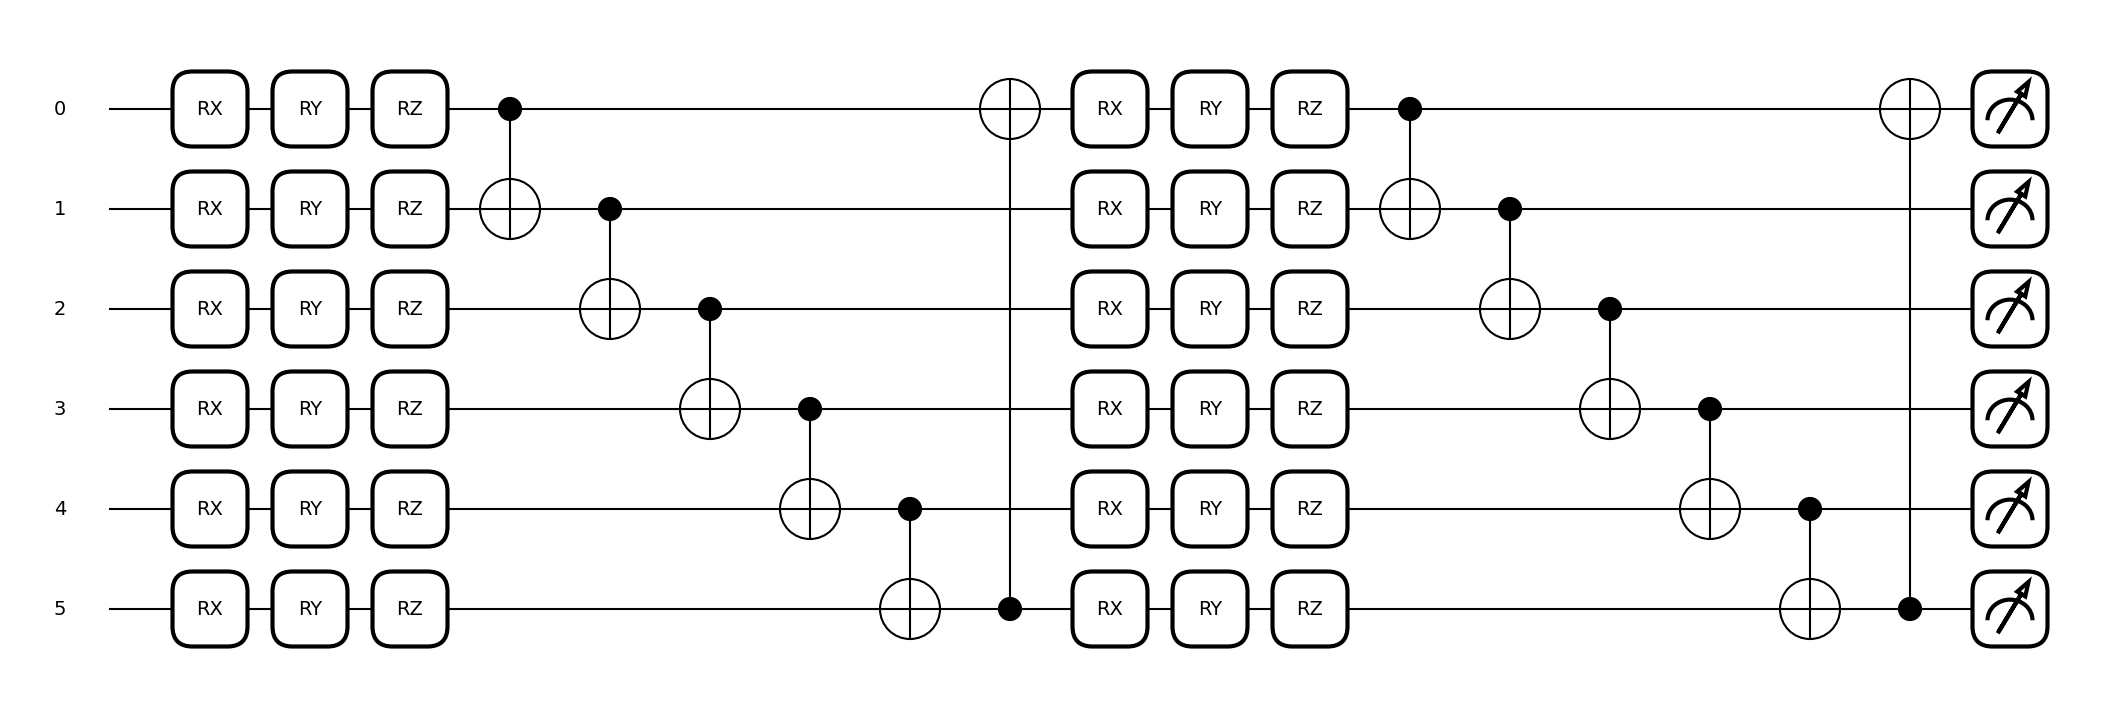

In [111]:
print(qml.draw_mpl(state_vec)())

### Optimizing

In [112]:
loss = []

optimizer = optim.SGD([w], lr = 0.05, momentum = 1) #lr : learning rate, SGD : gradient descent
for iter in range(N_iter):
    #cost function
    cost = my_cost()#main_circuit(w,C1,num_of_layers)
    loss.append(float(cost))
    #Optimizing step
    optimizer.zero_grad() #gradient 초기화
    cost.backward() #gradient 계산
    optimizer.step() #함수 개선

### Result check

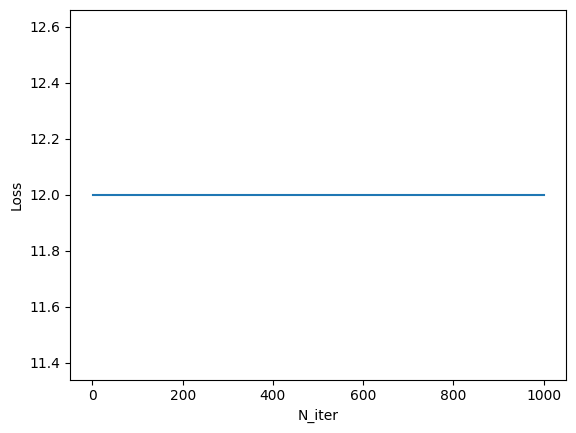

In [113]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,N_iter+1),loss)
plt.xlabel('N_iter')
plt.ylabel('Loss')
plt.show()

In [87]:
result_state = probs_to_str()
print(result_state)
result_index = str_to_indexes(result_state) + [c[0] * n + c[1] for c in C1.horses]
print(result_index)
result_horses = [[e // n, e % n] for e in result_index]
C2 = Chess(4, result_horses)

print(classical_cost_f(result_index))

print(result_horses)
C2.draw()

010101
[5, 9, 13, 1]
tensor(12., requires_grad=True)
[[1, 1], [2, 1], [3, 1], [0, 1]]
□◆□□
□◆□□
□◆□□
□◆□□


In [18]:
# expect_E = main_circuit(w,C1,num_of_layers)#.item()
m_result = list(main_circuit())
M_index = m_result.index(max(m_result))
bit_string = bin(M_index)[2:]

state_f = state_vec()
ans=0

expect_E = my_cost()
print("expectation value(loss) of energy : ", expect_E)
print('result :', bit_string)
result = [bit_string]

[tensor(0.0169, grad_fn=<UnbindBackward0>), tensor(0.0044, grad_fn=<UnbindBackward0>), tensor(0.0102, grad_fn=<UnbindBackward0>), tensor(0.0007, grad_fn=<UnbindBackward0>), tensor(0.0264, grad_fn=<UnbindBackward0>), tensor(0.0163, grad_fn=<UnbindBackward0>), tensor(0.0280, grad_fn=<UnbindBackward0>), tensor(0.0059, grad_fn=<UnbindBackward0>), tensor(0.0022, grad_fn=<UnbindBackward0>), tensor(0.0114, grad_fn=<UnbindBackward0>), tensor(0.0660, grad_fn=<UnbindBackward0>), tensor(0.0129, grad_fn=<UnbindBackward0>), tensor(0.0084, grad_fn=<UnbindBackward0>), tensor(0.0016, grad_fn=<UnbindBackward0>), tensor(0.0360, grad_fn=<UnbindBackward0>), tensor(0.0047, grad_fn=<UnbindBackward0>), tensor(0.0090, grad_fn=<UnbindBackward0>), tensor(0.0556, grad_fn=<UnbindBackward0>), tensor(0.0010, grad_fn=<UnbindBackward0>), tensor(0.0009, grad_fn=<UnbindBackward0>), tensor(0.0161, grad_fn=<UnbindBackward0>), tensor(0.1039, grad_fn=<UnbindBackward0>), tensor(0.0010, grad_fn=<UnbindBackward0>), tensor(0.0

In [17]:
'''
for i in range(2 ** (board_size * board_size)):
    print(f"probability of getting |{i}> :",abs(state_f[i])**2)
'''
for i in range(2 ** (board_size * board_size)):
    if abs(state_f[i]) ** 2 > 0.1:
        result.append((bin(i)[2:], abs(state_f[i].item())**2))
        print(format(i,'b')+"is ground state with probability",abs(state_f[i].item())**2)


IndexError: index 64 is out of bounds for dimension 0 with size 64

## Result Chk

In [ ]:
result.sort(key = lambda x:x[1])
result = result [::-1]
print(result)

[('100001000011000', 0.6200044296810338), ('100001000010001', 0.2062962210384992)]


In [ ]:
def answer(result : dict):
    n = C1.size
    for e in result:
      print('===========================')
      ans = int(e)#[0])
      coordinates = []
      cnt = n * n - 1
      while cnt >= 0:
        if ans % 10 == 1:
          coordinates.append([cnt // n, cnt % n])
        cnt -= 1
        ans //= 10
      tempC = Chess(n, coordinates)
      tempC.draw()
      print('===========================')

    '''
    for ans in result:
      temp_board  = [[0 for _ in range(n) for _ in range(n)]]
      cnt = n ** 2 - 1
      while cnt > 0:
        i, j = cnt // n, cnt % n
        temp_board[i][j] = ans % 10
        ans //= 10
        cnt -= 1
    '''
    return

answer(result)

□◆□□
□□◆□
◆□□□
□□◆□
